In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from flavors.activate_function import ActivateFunctionController, ActivateFunctions

In [20]:
Lx = 5.0
Ly = 1.0
T = 1.0
nu = 0.05

U = 1

barrier_Lx = 0.2
barrier_Ly = 0.2

barrier_x = 1
barrier_y = Ly / 2 - barrier_Ly / 2


class NavierStokesModel(nn.Module):
    def __init__(self):
        super(NavierStokesModel, self).__init__()

        self.activation_func = ActivateFunctionController(
            activate_func=ActivateFunctions.AdaptiveBlendingUnit, args=dict()
        ).get()

        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.activation_func(self.fc1(x))
        x = self.activation_func(self.fc2(x))
        x = self.activation_func(self.fc3(x))
        return self.fc4(x)


model = NavierStokesModel()


def compute_pde(xyt):
    xyt.requires_grad_(True)
    up = model(xyt)
    u, v, p = up[:, 0], up[:, 1], up[:, 2]

    u_x = torch.autograd.grad(u.sum(), xyt, create_graph=True)[0][:, 0]
    u_y = torch.autograd.grad(u.sum(), xyt, create_graph=True)[0][:, 1]
    u_t = torch.autograd.grad(u.sum(), xyt, create_graph=True)[0][:, 2]
    v_x = torch.autograd.grad(v.sum(), xyt, create_graph=True)[0][:, 0]
    v_y = torch.autograd.grad(v.sum(), xyt, create_graph=True)[0][:, 1]
    v_t = torch.autograd.grad(v.sum(), xyt, create_graph=True)[0][:, 2]
    p_x = torch.autograd.grad(p.sum(), xyt, create_graph=True)[0][:, 0]
    p_y = torch.autograd.grad(p.sum(), xyt, create_graph=True)[0][:, 1]

    u_xx = torch.autograd.grad(u_x.sum(), xyt, create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_y.sum(), xyt, create_graph=True)[0][:, 1]
    v_xx = torch.autograd.grad(v_x.sum(), xyt, create_graph=True)[0][:, 0]
    v_yy = torch.autograd.grad(v_y.sum(), xyt, create_graph=True)[0][:, 1]

    continuity = u_x + v_y

    momentum_x = u_t + v_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    momentum_y = u_t + v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)

    return continuity, momentum_x, momentum_y


def boundary_conditions():
    num_points = 1000
    t = T * np.random.random(num_points)
    bottom_bc = torch.tensor(
        np.stack(
            [np.random.uniform(0, Lx, num_points), np.zeros(num_points), t], axis=-1
        ),
        requires_grad=False,
    ).float()
    left_bc = torch.tensor(
        np.stack(
            [np.zeros(num_points), np.random.uniform(0, Ly, num_points), t], axis=-1
        ),
        requires_grad=False,
    ).float()
    top_bc = torch.tensor(
        np.stack(
            [np.random.uniform(0, Lx, num_points), np.full(num_points, Ly), t], axis=-1
        ),
        requires_grad=False,
    ).float()
    right_bc = torch.tensor(
        np.stack(
            [np.full(num_points, Lx), np.random.uniform(0, Ly, num_points), t], axis=-1
        ),
        requires_grad=False,
    ).float()

    bottom_predict = model(bottom_bc)
    left_predict = model(left_bc)
    top_predict = model(top_bc)
    right_predict = model(right_bc)

    u, v, p = left_predict[:, 0], left_predict[:, 1], left_predict[:, 2]
    bc_loss = torch.mean(p**2)

    u, v, p = top_predict[:, 0], top_predict[:, 1], top_predict[:, 2]
    bc_loss += torch.mean((u - U)**2 + v**2)

    u, v, p = bottom_predict[:, 0], bottom_predict[:, 1], bottom_predict[:, 2]
    bc_loss += torch.mean(u**2 + v**2)
    u, v, p = right_predict[:, 0], right_predict[:, 1], right_predict[:, 2]
    bc_loss += torch.mean(p**2)

    return bc_loss


def generate_data(num_points):
    x = np.random.uniform(0, Lx, num_points)
    y = np.random.uniform(0, Ly, num_points)
    t = np.random.uniform(0, T, num_points)
    xyt = np.stack([x, y, t], axis=-1)
    return torch.tensor(xyt, requires_grad=True).float()


def loss_function(xyt):
    continuity, momentum_x, momentum_y = compute_pde(xyt)
    pde_loss = (
        torch.mean(continuity**2)
        + torch.mean(momentum_x**2)
        + torch.mean(momentum_y**2)
    )
    bc_loss = boundary_conditions()
    total_loss = pde_loss + bc_loss
    return total_loss


In [21]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 10000
num_points = 1000
for epoch in range(num_epochs):
    xyt = generate_data(num_points)
    optimizer.zero_grad()
    loss = loss_function(xyt)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

print("Training completed.")


Epoch 0, Loss: 1.0547285079956055
Epoch 100, Loss: 0.0013483414659276605
Epoch 200, Loss: 0.0003293718909844756
Epoch 300, Loss: 0.0001484669337514788
Epoch 400, Loss: 9.305703861173242e-05
Epoch 500, Loss: 7.33284032321535e-05
Epoch 600, Loss: 7.086776895448565e-05
Epoch 700, Loss: 0.00015375875227618963
Epoch 800, Loss: 4.767731297761202e-05
Epoch 900, Loss: 3.5558390663936734e-05
Epoch 1000, Loss: 4.2421757825650275e-05
Epoch 1100, Loss: 9.62253543548286e-05
Epoch 1200, Loss: 6.21783547103405e-05
Epoch 1300, Loss: 2.513558865757659e-05
Epoch 1400, Loss: 4.586363866110332e-05
Epoch 1500, Loss: 0.00024655257584527135
Epoch 1600, Loss: 3.5937260690843686e-05
Epoch 1700, Loss: 2.0084797142772004e-05
Epoch 1800, Loss: 1.8221513528260402e-05
Epoch 1900, Loss: 2.596462218207307e-05
Epoch 2000, Loss: 2.0542307538562454e-05
Epoch 2100, Loss: 4.6577450120821595e-05
Epoch 2200, Loss: 1.555736525915563e-05
Epoch 2300, Loss: 2.6125882868655026e-05
Epoch 2400, Loss: 2.3644317479920574e-05
Epoch 2

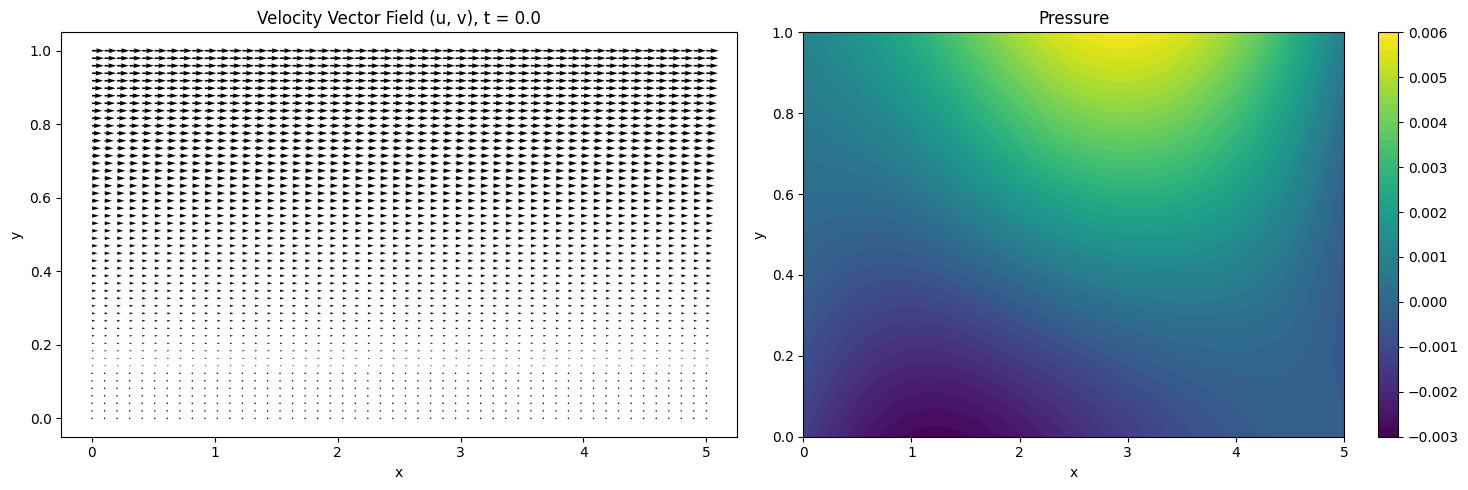

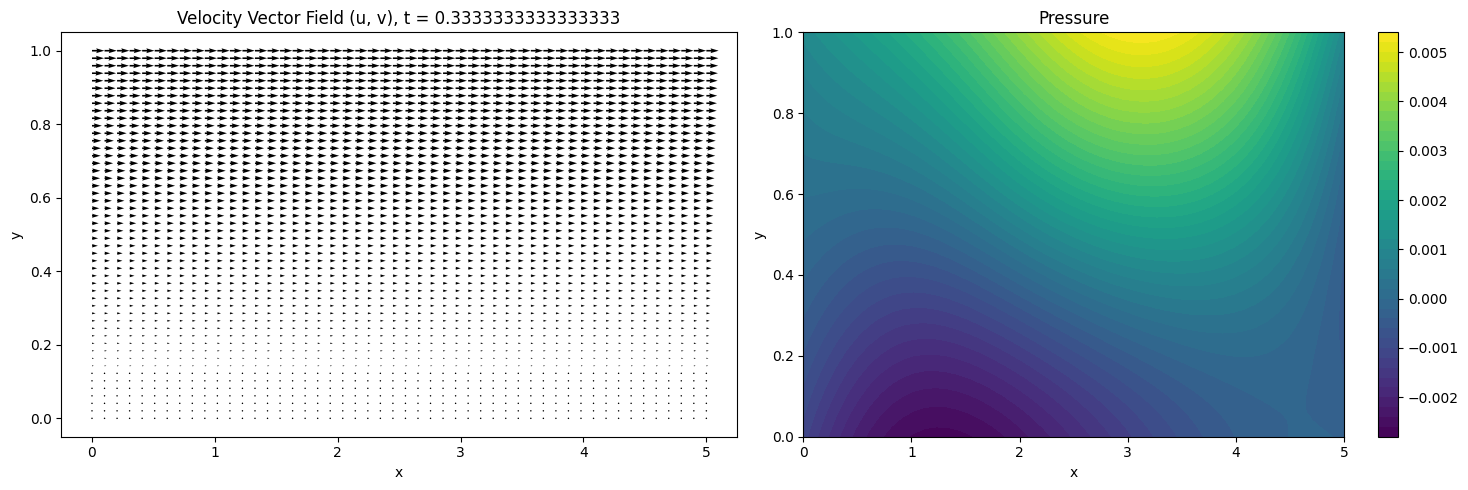

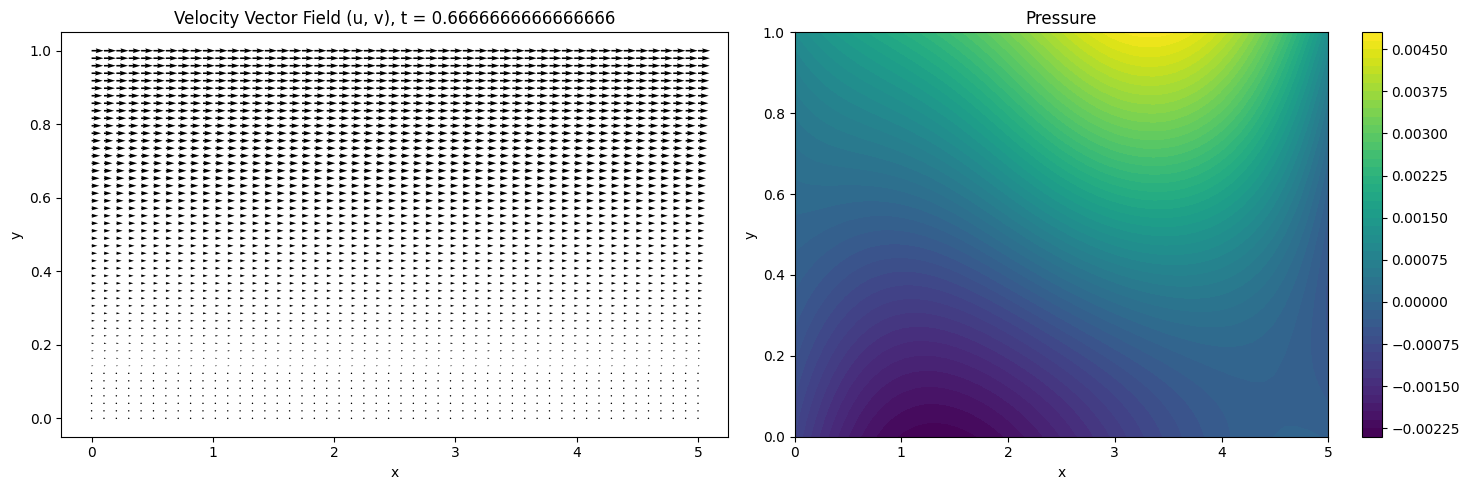

IndexError: index 4 is out of bounds for axis 2 with size 4

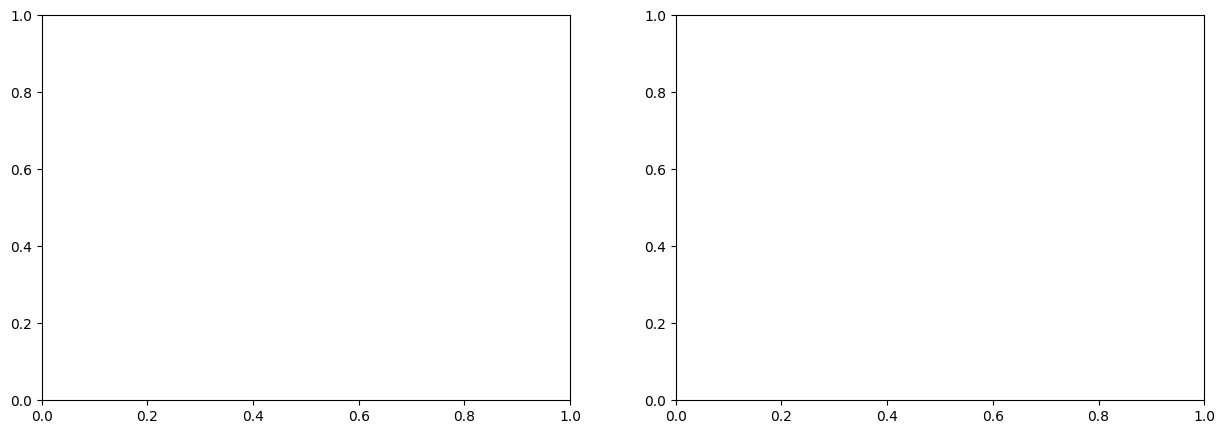

In [22]:

nx, ny, nt = 50, 50, 4
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
t = np.linspace(0, T, nt)
X, Y, t_grid = np.meshgrid(x, y, t)
XYT = np.stack([X.flatten(), Y.flatten(), t_grid.flatten()], axis=-1)
XYT_tensor = torch.tensor(XYT, requires_grad=False).float()

X, Y = np.meshgrid(x, y)
XY = np.stack([X.flatten(), Y.flatten()], axis=-1)


with torch.no_grad():
    predictions = model(XYT_tensor).numpy()

U = predictions[:, 0].reshape((ny, nx, nt))
V = predictions[:, 1].reshape((ny, nx, nt))
P = predictions[:, 2].reshape((ny, nx, nt))


for t_i in t:
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].quiver(
        X, Y, U[:, :, int(t_i * nt)], V[:, :, int(t_i * nt)], scale=10, scale_units="xy"
    )
    axs[0].set_title(f"Velocity Vector Field (u, v), t = {t_i}")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    c3 = axs[1].contourf(X, Y, P[:, :, int(t_i * nt)], levels=50, cmap="viridis")
    axs[1].set_title("Pressure")
    fig.colorbar(c3, ax=axs[1])
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("y")

    plt.tight_layout()
    plt.show()
